# 01 Library

In [1]:
import os
import pickle
import warnings
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn.impute as skl_imp
from dirty_cat import SimilarityEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer, OneHotEncoder

from common.utils import *

warnings.filterwarnings('ignore')

# 02 Load Data

In [2]:
path_in = os.path.join(os.getcwd(), 'data/input/')
path_out = os.path.join(os.getcwd(), 'data/output/')
path_model = os.path.join(os.getcwd(), 'models/')

In [3]:
paths = [path_in, path_out, path_model]
for path in paths:
    os.makedirs(path, exist_ok=True)

In [4]:
files = []
for (dirpath, dirnames, filenames) in os.walk(path_in):
    files.extend(filenames)

In [5]:
file_test = os.path.join(path_in, 'test-set-values.csv')
file_values = os.path.join(path_in, 'training-set-values.csv')
file_labels = os.path.join(path_in, 'training-set-labels.csv')

In [6]:
df_test_values = pd.read_csv(file_test)
df_train_values = pd.read_csv(file_values)
df_train_labels = pd.read_csv(file_labels)

In [7]:
df_test_values.shape, df_train_values.shape

((14850, 40), (59400, 40))

In [8]:
DataPre = pd.concat([df_train_values, df_test_values], axis=0, keys=['train','test']).reset_index(level=[0])

# 03 Pre-processing

## 03.01 Info and Describe

In [9]:
DataPre.date_recorded = pd.to_datetime(DataPre.date_recorded)
# DataPre.gps_height = DataPre.gps_height.astype(float)

In [10]:
DataPre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   level_0                74250 non-null  object        
 1   id                     74250 non-null  int64         
 2   amount_tsh             74250 non-null  float64       
 3   date_recorded          74250 non-null  datetime64[ns]
 4   funder                 69743 non-null  object        
 5   gps_height             74250 non-null  int64         
 6   installer              69718 non-null  object        
 7   longitude              74250 non-null  float64       
 8   latitude               74250 non-null  float64       
 9   wpt_name               74248 non-null  object        
 10  num_private            74250 non-null  int64         
 11  basin                  74250 non-null  object        
 12  subvillage             73780 non-null  object        
 13  region

In [11]:
DataPre.head()

,level_0,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,train,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,train,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,train,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,train,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,train,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## 03.01 GIS

In [12]:
DataGeo = DataPre[['basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'gps_height', 'longitude', 'latitude']]

In [13]:
list_basin = DataGeo[DataGeo.gps_height.eq(0.0)&DataGeo.longitude.eq(0.000000)&DataGeo.latitude.eq(-2.000000e-08)].basin.unique()
DataBasin = DataGeo[DataGeo.basin.isin(list_basin)]
cols = DataBasin.columns
idx = DataBasin.index

In [14]:
DataBasin.loc[DataBasin.gps_height.eq(0.0)&DataBasin.longitude.eq(0.000000)&DataBasin.latitude.eq(-2.000000e-08), ['gps_height','longitude', 'latitude']] = np.nan, np.nan, np.nan
DataBasin.reset_index(drop=True, inplace=True)

In [15]:
# Dictionary
g = defaultdict(LabelEncoder)
# Encoding the variable
fit = DataBasin.select_dtypes(exclude=['int', 'float']).apply(lambda x: g[x.name].fit_transform(x))

# Using the dictionary to label future data
cols_txt = DataBasin.select_dtypes(exclude=['int', 'float']).columns
DataBasin.loc[:, cols_txt] = DataBasin.select_dtypes(exclude=['int', 'float']).apply(lambda x: g[x.name].transform(x))

In [16]:
# Imputación multivariante Iterativa
imputer_itImp = skl_imp.IterativeImputer(max_iter=100, random_state=0)
DataBasin = imputer_itImp.fit_transform(DataBasin)
DataBasin = pd.DataFrame(DataBasin, columns=cols, index=idx)

In [17]:
# Inverse the encoded
DataBasin.loc[:, cols_txt] = fit.apply(lambda x: g[x.name].inverse_transform(x))

In [18]:
DataPre.loc[DataPre.basin.isin(list_basin), ['gps_height', 'longitude', 'latitude']] = DataBasin[['gps_height', 'longitude', 'latitude']]

## 03.02 Variables con valores unicos iguales o menores a 30 categorias

In [19]:
DataPre.pop('recorded_by')

0        GeoData Consultants Ltd
1        GeoData Consultants Ltd
2        GeoData Consultants Ltd
3        GeoData Consultants Ltd
4        GeoData Consultants Ltd
                  ...           
14845    GeoData Consultants Ltd
14846    GeoData Consultants Ltd
14847    GeoData Consultants Ltd
14848    GeoData Consultants Ltd
14849    GeoData Consultants Ltd
Name: recorded_by, Length: 74250, dtype: object

In [20]:
# Para las variables booleanas, se han imputado los valores nulos usando el cociente de los valores disponibles.
# Con el fin de preservar las potenciales relaciones.

In [21]:
public_prop = DataPre['public_meeting'].value_counts(normalize=True)
public_prop

public_meeting
True     0.909466
False    0.090534
Name: proportion, dtype: float64

In [22]:
permit_prop = DataPre['permit'].value_counts(normalize=True)
permit_prop

permit
True     0.689868
False    0.310132
Name: proportion, dtype: float64

In [23]:
DataPre['public_meeting'].fillna(pd.Series(np.random.choice([True, False],
                                                     p=[public_prop[True], public_prop[False]],
                                                     size=len(DataPre))), inplace=True)
DataPre['permit'].fillna(pd.Series(np.random.choice([True, False],
                                                    p=[permit_prop[True], permit_prop[False]],
                                                    size=len(DataPre))), inplace=True)

In [24]:
DataPre['public_meeting'] = DataPre['public_meeting'].astype(float)
DataPre['permit'] = DataPre['permit'].astype(float)

In [25]:
clean_cat = ['basin',
             'region',
             'scheme_management',
             'extraction_type',
             'extraction_type_group',
             'extraction_type_class',
             'management',
             'management_group',
             'payment',
             'payment_type',
             'water_quality',
             'quality_group',
             'quantity',
             'quantity_group',
             'source',
             'source_type',
             'source_class',
             'waterpoint_type',
             'waterpoint_type_group']

In [26]:
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.lower())
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.replace(' / ', ' ', regex=True))
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.replace('/', ' ', regex=True))
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.replace('other - ', '', regex=True))
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.replace('other ', '', regex=True))
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.replace('-', ' ', regex=True))
DataPre[clean_cat] = DataPre[clean_cat].apply(lambda x: x.str.strip())

## 03.03 Variables con valores unicos mayores a 30 categorias

In [27]:
DataPre.pop('scheme_name')

0                              Roman
1                                NaN
2        Nyumba ya mungu pipe scheme
3                                NaN
4                                NaN
                    ...             
14845                  Bagamoyo wate
14846                            NaN
14847                            NaN
14848      Mradi wa maji wa maposeni
14849                         DANIDA
Name: scheme_name, Length: 74250, dtype: object

In [28]:
dirty_cat = ['lga', 'subvillage', 'ward', 'wpt_name', 'installer', 'funder']

In [29]:
DataPre[dirty_cat] = DataPre[dirty_cat].apply(lambda x: x.str.replace('[^\w+\s]', '', regex=True))
DataPre[dirty_cat] = DataPre[dirty_cat].apply(lambda x: x.str.strip())
DataPre[dirty_cat] = DataPre[dirty_cat].apply(lambda x: x.str.lower())

In [30]:
DataPre[dirty_cat].info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lga         74250 non-null  object
 1   subvillage  73780 non-null  object
 2   ward        74250 non-null  object
 3   wpt_name    74248 non-null  object
 4   installer   69718 non-null  object
 5   funder      69743 non-null  object
dtypes: object(6)
memory usage: 4.0+ MB


## 03.04 Variables continuas y temporales

In [31]:
DataPre.pop('num_private')

0        0
1        0
2        0
3        0
4        0
        ..
14845    0
14846    0
14847    0
14848    0
14849    0
Name: num_private, Length: 74250, dtype: int64

### 03.04.01 construction_year

In [32]:
mean_cons_year = DataPre.loc[~DataPre.construction_year.isna(), ['construction_year']].mean().round(0).construction_year

In [33]:
DataPre.loc[DataPre.construction_year.eq(0), ['construction_year']] = mean_cons_year

In [34]:
DataPre['pump_age'] = DataPre.date_recorded.dt.year - DataPre.construction_year

### 03.04.02 date_recorded

In [35]:
DataPre['ordinal_recorded'] = DataPre['date_recorded'].apply(lambda x: x.toordinal())

## 03.05 Data transformation pipeline

In [36]:
# DataPre = DataPre[['level_0', 'id', 'extraction_type_class', 'payment', 'quantity', 'quantity_group', 'waterpoint_type', 'lga']]

In [37]:
clean_cols = {
     # 'id':                    'numerical' # testigo
     'basin':                 'modified-label'
    ,'region':                'modified-label'
    ,'scheme_management':     'modified-label'
    ,'extraction_type':       'modified-label' # model_2024-04-08_215108: 0.8137 / reintento: 0.8135
    ,'extraction_type_group': 'modified-label'
    ,'extraction_type_class': 'one-hot' # model_2024-04-09_222119: 0.8189
    ,'management':            'modified-label'
    ,'management_group':      'modified-label'
    ,'payment':               'one-hot' # model_2024-04-09_222119: 0.8189
    ,'payment_type':          'modified-label'
    ,'water_quality':         'modified-label'
    ,'quality_group':         'modified-label'
    ,'quantity':              'one-hot' # model_2024-04-08_214513: 0.8187
    ,'quantity_group':        'one-hot' # model_2024-04-09_222119: 0.8189
    ,'source':                'modified-label'
    ,'source_type':           'modified-label'
    ,'source_class':          'modified-label'
    ,'waterpoint_type':       'one-hot' # model_2024-04-08_214513: 0.8187
    ,'waterpoint_type_group': 'modified-label'
    ,'public_meeting':        'numerical'
    ,'permit':                'numerical'
    ,'region_code':           'numerical'
    ,'district_code':         'numerical'
    ,'population':            'numerical'
    ,'construction_year':     'numerical'
    ,'amount_tsh':            'numerical'
    ,'gps_height':            'numerical'
    ,'longitude':             'numerical'
    ,'latitude':              'numerical'
    ,'pump_age':              'numerical' # variable adicional
    ,'ordinal_recorded':      'numerical' # variable adicional
    }

In [38]:
dirty_cols = {
     'lga':        'similarity'
    ,'subvillage': 'modified-label'
    ,'ward':       'modified-label' # 'similarity' -> model_2024-04-08_213437: 0.8071
    ,'wpt_name':   'modified-label'
    ,'installer':  'modified-label' # 'similarity' -> model_2024-04-08_215108: 0.8137
    ,'funder':     'modified-label' # similarity roc auc 0.893589596536799
    }

In [39]:
encoders_dict = {
    'one-hot':        OneHotEncoder(handle_unknown='ignore'),
    'similarity':     SimilarityEncoder(similarity='ngram'),
    'numerical':      FunctionTransformer(None),
    'ordinal':        OrdinalEncoder(handle_unknown='ignore'),
    'label':          LabelEncoder(),
    'modified-label': ModifiedLabelEncoder()
}

In [40]:
data_pipe = data_pipeline(clean_cols, dirty_cols, encoders_dict) # función customizada
transformed_data = data_pipe.fit_transform(DataPre)

In [41]:
transformed_data = pd.DataFrame(transformed_data)

## 03.06 Tratamiento de valores atípicos 

In [42]:
# transformed_data = transformed_data.apply(lambda x: gestiona_outliers(x,clas='winsor'))

## 03.07 Data preparation 

In [43]:
today = datetime.today().strftime('%Y-%m-%d_%H%M%S')

In [44]:
DataTransform = pd.concat([DataPre[['level_0', 'id']].reset_index(drop=True), transformed_data], axis=1)

In [45]:
DataTrain = pd.merge(df_train_labels, DataTransform[DataTransform['level_0']=='train'].drop(columns=['level_0']), how='left', on='id')

In [46]:
DataTrain.to_csv(path_out + f'DataTrain_{today}.csv', index=False)

In [47]:
X = DataTrain.drop(columns=['status_group', 'id'])
X_submission = DataTransform[DataTransform['level_0']=='test'].drop(columns=['level_0', 'id'])
y = DataTrain.status_group

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 04 Modeling

## 04.01 Modeling

In [49]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
# model.fit(X, y)

RandomForestClassifier()

In [50]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

## 04.02 Save the model

In [51]:
# # save
# with open(path_model + f'model_{today}.pkl','wb') as f:
#     pickle.dump(model,f)

In [52]:
# # load
# with open(path_model + f'model_{today}.pkl', 'rb') as f:
#     model  = pickle.load(f)

# model.predict(X[0:1])

## 04.03 Evaluation metrics

### 04.03.01 ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

In [53]:
classes = model.classes_
classes

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

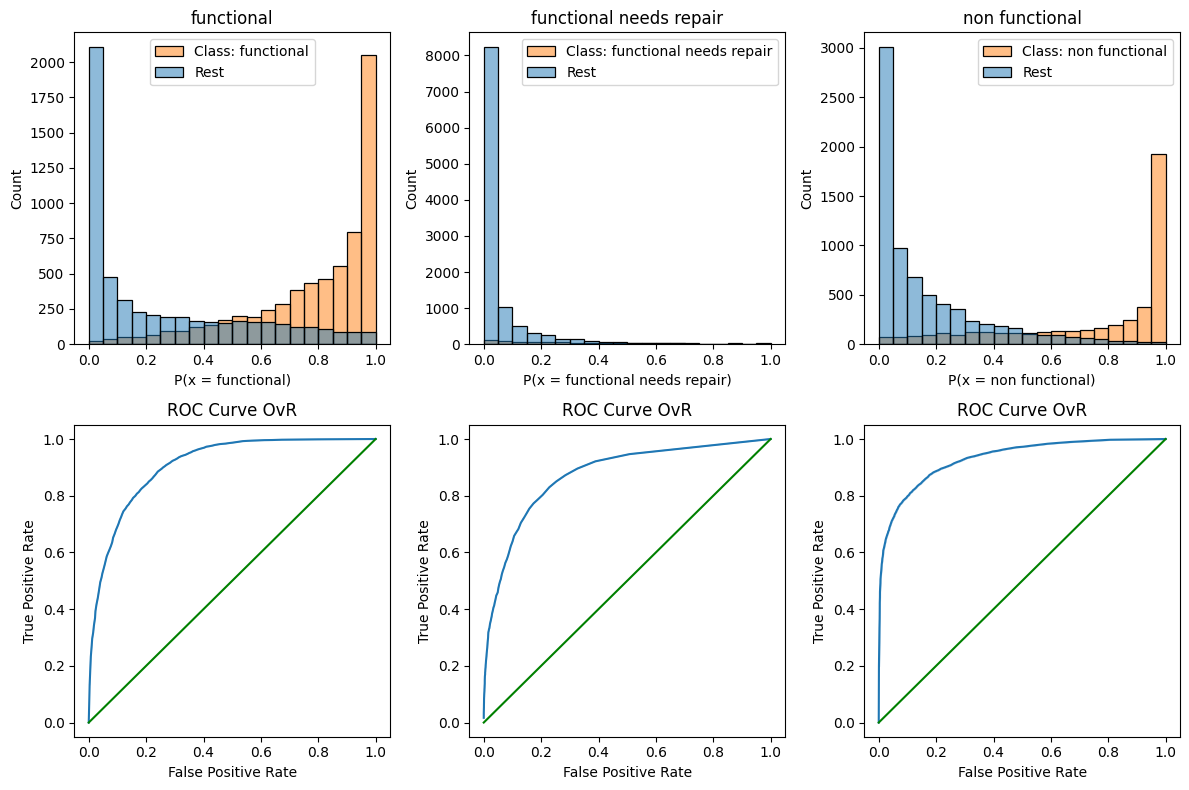

In [54]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [55]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

functional ROC AUC OvR: 0.9079
functional needs repair ROC AUC OvR: 0.8728
non functional ROC AUC OvR: 0.9310
average ROC AUC OvR: 0.9039


In [56]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.9038966944090799

### 04.03.02 Feature importance

In [57]:
imp = {}
for i in range(len(X_train.columns)):
    imp[X_train.columns[i]] = [model.feature_importances_[i]]

features_importance = pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"])
features_importance.sort_values("Importance", ascending=False).head(20)#.style.background_gradient()

,Importance
53,0.068397
54,0.068103
184,0.054944
182,0.050278
52,0.038506
29,0.037872
56,0.037620
24,0.037485
183,0.029665
49,0.027184


In [58]:
# features = DataPre.drop(columns=['level_0', 'id']).columns.tolist()
# dic = {a:b for a, b in enumerate(features)}

In [59]:
# features_names = pd.DataFrame.from_dict(dic, orient="index", columns=["features_names"]).reset_index(names='features')

In [60]:
# top_20 = features_names.merge(features_importance.reset_index(names='features').sort_values("Importance", ascending=False).head(20), on='features', how='left')

In [61]:
# print(top_20.dropna()['features_names'].tolist())

## 04.04 Prediction and submission

In [62]:
y_submission = model.predict(X_submission)

In [63]:
DataSubmission = {'id': DataTransform[DataTransform['level_0']=='test']['id'].values, 'status_group':y_submission}
df_submission = pd.DataFrame(DataSubmission)

In [64]:
df_submission.to_csv(path_out + f'SubmissionFormat_{today}.csv', index=False)